In [1]:
import numpy as np
import pyedflib
from matplotlib import pyplot as plt
from nitime import utils
from nitime import algorithms as alg
from nitime.timeseries import TimeSeries
from nitime.viz import plot_tseries
import csv
import pywt
import scipy.stats as sp
from scipy import signal
from spectrum import *
from os import listdir
from os.path import isfile, join
from wyrm import processing as proc
from wyrm.types import Data
from wyrm.io import convert_mushu_data
from sklearn import metrics
from wyrm.processing import calculate_csp, segment_dat, apply_csp, append_epo
from wyrm.processing import select_channels
from wyrm.processing import swapaxes
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import OrthogonalMatchingPursuitCV

In [3]:
channels = [str(i) for i in xrange(1,61)]
data_files_location = '4_class_data'
files1  = [f for f in listdir(data_files_location)]

In [4]:
## wavelet features


def wavelet_features(epoch):
    cA_values = []
    cD_values = []
    cA_mean = []
    cA_std = []
    cA_Energy = []
    cD_mean = []
    cD_std = []
    cD_Energy = []
    Entropy_D = []
    Entropy_A = []
    features = []
    for i in range(len(epoch)):
        cA, cD = pywt.dwt(epoch[i, :], 'coif1')
        cA_values.append(cA)
        cD_values.append(
            cD)  #calculating the coefficients of wavelet transform.
    for x in range(len(epoch)):
        cA_Energy.append(abs(np.sum(np.square(cA_values[x]))))
        features.append(abs(np.sum(np.square(cA_values[x]))))

    for x in range(len(epoch)):
        cD_Energy.append(abs(np.sum(np.square(cD_values[x]))))
        features.append(abs(np.sum(np.square(cD_values[x]))))

    for x in range(len(epoch)):
        Entropy_D.append(
            abs(
                np.sum(
                    np.square(cD_values[x]) * np.log(np.square(
                        cD_values[x])))))
        features.append(
            abs(
                np.sum(
                    np.square(cD_values[x]) * np.log(np.square(
                        cD_values[x])))))

    for x in range(len(epoch)):
        Entropy_A.append(
            abs(
                np.sum(
                    np.square(cA_values[x]) * np.log(np.square(
                        cA_values[x])))))
        features.append(
            abs(
                np.sum(
                    np.square(cA_values[x]) * np.log(np.square(
                        cA_values[x])))))

    return features

In [5]:
## Band Pass features


def bandpowers(segment):
    features = []
    for i in range(len(segment)):
        f, Psd = signal.welch(segment[i, :], 100)
        power1 = 0
        power2 = 0
        power3 = 0
        f1 = []
        for j in range(0, len(f)):
            if (f[j] >= 4 and f[j] <= 13):
                power1 += Psd[j]
            if (f[j] >= 14 and f[j] <= 20):
                power2 += Psd[j]
            if (f[j] > 20 and f[j] < 30):
                power3 += Psd[j]
        features.append(power1)
        features.append(power2)
    return features

In [6]:
subjects = ['k3b', 'k6b', 'l1b']
location = data_files_location + '/' + subjects[1] + '_markers.csv'
mark = np.genfromtxt(location, delimiter=",")

In [7]:
##Subject 1
sub = 0
location_data1 = data_files_location + '/' + subjects[sub] + '_data.csv'
location_markers1 = data_files_location + '/' + subjects[sub] + '_markers.csv'

data = np.genfromtxt(location_data1, delimiter=",")
markers = np.genfromtxt(location_markers1, delimiter=",")

train_markers1 = [(float(events[0]), int(events[1])) for events in markers
                  if (events[1] >= 1 and events[1] <= 4)]
train_mark_subject1 = []
for events in train_markers1:
    train_mark_subject1.append((float(events[0]) + 750.0, str(events[1])))
    train_mark_subject1.append((float(events[0]) + 875.0, str(events[1])))
    train_mark_subject1.append((float(events[0]) + 1000.0, str(events[1])))
    train_mark_subject1.append((float(events[0]) + 1125.0, str(events[1])))
    train_mark_subject1.append((float(events[0]) + 1250.0, str(events[1])))
    train_mark_subject1.append((float(events[0]) + 1375.0, str(events[1])))
    train_mark_subject1.append((float(events[0]) + 1500.0, str(events[1])))
    train_mark_subject1.append((float(events[0]) + 1625.0, str(events[1])))
    #train_mark_subject1.append((float(events[0])+1750.0,str(events[1])))

train_mark_subject1 = np.array(train_mark_subject1)

markers_subject1_class_1 = [(float(events[0]), events[1])
                            for events in train_mark_subject1
                            if events[1] == '1']
markers_subject1_class_2 = [(float(events[0]), events[1])
                            for events in train_mark_subject1
                            if events[1] == '2']
markers_subject1_class_3 = [(float(events[0]), events[1])
                            for events in train_mark_subject1
                            if events[1] == '3']
markers_subject1_class_4 = [(float(events[0]), events[1])
                            for events in train_mark_subject1
                            if events[1] == '4']

cnt1 = convert_mushu_data(data, markers_subject1_class_1, 125, channels)
cnt2 = convert_mushu_data(data, markers_subject1_class_2, 125, channels)
cnt3 = convert_mushu_data(data, markers_subject1_class_3, 125, channels)
cnt4 = convert_mushu_data(data, markers_subject1_class_4, 125, channels)

md = {'class 1': ['1'], 'class 2': ['2'], 'class 3': ['3'], 'class 4': ['4']}

epoch_subject1_class1 = segment_dat(cnt1, md, [0, 1000])
epoch_subject1_class2 = segment_dat(cnt2, md, [0, 1000])
epoch_subject1_class3 = segment_dat(cnt3, md, [0, 1000])
epoch_subject1_class4 = segment_dat(cnt4, md, [0, 1000])

In [8]:
# Append all epochs

class1_epochs = epoch_subject1_class1

class2_epochs = epoch_subject1_class2

class3_epochs = epoch_subject1_class3

class4_epochs = epoch_subject1_class4

temp1_epo1 = append_epo(class1_epochs, class2_epochs)
temp2_epo2 = append_epo(class3_epochs, class4_epochs)
final_epoch = append_epo(temp1_epo1, temp2_epo2)
print(final_epoch.data.shape)

(1440, 125, 60)


In [9]:
class1_epochs.axes[0].size

360

In [10]:
## Build the two dictionaries

# Dictionary with band power features
#form the dictionary using bandpower features where each column is a data point.

#For class 1
dictionary1 = []
dictionary2 = []
targets_bp = []
targets_we = []
for i in range(len(final_epoch.axes[0])):
    segment = final_epoch.data[i]
    segment = np.array(segment)
    segment = np.transpose(segment)

    #features = dct_features(segment)
    features1 = bandpowers(segment)
    #features = logvariance(segment)

    features2 = wavelet_features(segment)
    f1 = np.array(features1)
    f2 = np.array(features2)
    if (not (np.isnan(f1).any())):
        dictionary1.append(features1)
        targets_bp.append(final_epoch.axes[0][i])

    if (not (np.isnan(f2).any())):
        dictionary2.append(features2)
        targets_we.append(final_epoch.axes[0][i])

dictionary1 = np.array(dictionary1)
dictionary2 = np.array(dictionary2)

dictionary_bandpower = dictionary1
dictionary_wavelet = dictionary2

/anaconda/lib/python2.7/site-packages/scipy/signal/spectral.py:1637: UserWarning: nperseg = 256 is greater than input length  = 125, using nperseg = 125
  .format(nperseg, input_length))


In [12]:
#For wavelet

from scipy.sparse import coo_matrix
X_sparse = coo_matrix(dictionary_wavelet)

from sklearn.utils import resample
dictionary_wavelet, X_sparse, y_we = resample(
    dictionary_wavelet, X_sparse, targets_we, random_state=0)

In [22]:
#For Band Power

from scipy.sparse import coo_matrix
X_sparse = coo_matrix(dictionary_bandpower)

from sklearn.utils import resample
dictionary_bandpower, X_sparse, y_bp = resample(
    dictionary_bandpower, X_sparse, targets_bp, random_state=0)

In [23]:
# Plot CSP filter

polar_locations =[ [-90,-72], [90, 72],[-60, -51],[60, 51],[-45 ,0],[45, 0],[-60, 51],[60, -51],[-90, 72],[90, -72],[-90, -36],[90, 36],[-90, 0],
 [90, 0],[-90, 36],[90, -36],[45 ,90],[ 0, 0], [45, -90],[130, 80],[-31,-46],[31,46],[-31,46],[31, -46],[-69, -21],[69, 21],[-69, 21],
 [69, -21],[-113, -18],[113, 18],[-113, 18],[113, -18],[-49, -68],[49, 68],[-23, 0],[23, 0],[-49, 68],[49, -68],[-74, -68],[74, 68],
[-49, -29],[49, 29],[-49, 29],[49, -29],[-74, 68],[74 ,-68],[-74, -41],[74, 41],[-68, 0],[68, 0],[-74, 41], [74, -4]]

In [25]:
#for i in range(len(polar_locations)):
   # print(polar_locations[i][1])

In [26]:
import numpy as np
import math

positionx = []
positiony = []

In [27]:
for i in range(len(polar_locations)):
    x = polar_locations[i][0] * math.cos(polar_locations[i
                                                        ][1])
    y = polar_locations[i][0] * math.sin(polar_locations[i][1])
    
    positionx.append(x)
    positiony.append(y) 

In [28]:
for i in range(len(positionx)):
    if(positionx[i]<0):
        positionx[i] *= -1
        positionx[i] = -1 * (0.5/(-1*min(positionx)))*(positionx[i])
    elif(positionx[i]>0):
        positionx[i] = (0.5/max(positionx))*(positionx[i])
    elif(positionx[i]==0.):
        positionx[i] = 0
        
        
    if(positiony[i]<0):
        positiony[i] *= -1
        positiony[i] = -1 * (0.5/(-1*min(positiony)))*(positiony[i])
    elif(positiony[i]>0):
        positiony[i] = (0.5/max(positiony))*(positiony[i])
    elif(positiony[i]==0.):
        positiony[i] = 0

position = np.column_stack((positionx, positiony))

In [29]:
index = [0,4,15,19,51,55,88,92,111,113,13,21,49,57,86,94,17,53,90,114,34,36,70,72,32,38,68,74,30,40,66,76,16,18,52,54,89,101,6,7,33,37,69,73,103,107,14,20,50,56,87,93] 
a11 = []
a22 = []
a33 = []
a44 = []
b11 = []
b22 = []
b33 = []
b44 = []
for i in range(len(index)):
    a11.append(dictionary_wavelet[1,index[i]])
    a22.append(dictionary_wavelet[400,index[i]])
    a33.append(dictionary_wavelet[800,index[i]])
    a44.append(dictionary_wavelet[1380,index[i]])
    b11.append(dictionary_bandpower[1,index[i]])
    b22.append(dictionary_bandpower[400,index[i]])
    b33.append(dictionary_bandpower[800,index[i]])
    b44.append(dictionary_bandpower[1380,index[i]])


In [30]:
#Plot CSP filters

import numpy as np
import matplotlib.pyplot as plt

import mne


fig, axes = plt.subplots(2, 4)
mne.viz.plot_topomap(a11,position, axes=axes[0][0], show=False)
mne.viz.plot_topomap(a22,position, axes=axes[0][1], show=False)
mne.viz.plot_topomap(a33,position, axes=axes[0][2], show=False)
mne.viz.plot_topomap(a44,position, axes=axes[0][3], show=False)
mne.viz.plot_topomap(b11,position, axes=axes[1][0], show=False)
mne.viz.plot_topomap(b22,position, axes=axes[1][1], show=False)
mne.viz.plot_topomap(b33,position, axes=axes[1][2], show=False)
mne.viz.plot_topomap(b44,position, axes=axes[1][3], show=False)

fig.tight_layout()
fig.show()
plt.savefig('wavelet_scalplot.eps', format='eps', dpi=1000)

In [12]:
def calculate_accuracy(Xts, yts, D, minimum):
    y_pred1 = []
    y_pred2 = []
    y_pred3 = []
    y_pred4 = []
    diff = []
    class1_avg = 0
    class2_avg = 0
    class3_avg = 0
    class4_avg = 0
    counter1 = 0
    for i in range(len(Xts)):
        features = Xts[i]

        omp = OrthogonalMatchingPursuit(n_nonzero_coefs=75)
        omp.fit(D, features)
        coef = omp.coef_

        s1 = 0
        s2 = 0
        s3 = 0
        s4 = 0

        l1 = 0
        l2 = 0
        l3 = 0
        l4 = 0

        a1 = 0
        a2 = 0
        a3 = 0
        a4 = 0

        list1 = coef[0:minimum]
        list2 = coef[minimum:2 * minimum]
        list3 = coef[2 * minimum:3 * minimum]
        list4 = coef[3 * minimum:4 * minimum]

        c1 = (sum(z * z for z in list1))**(1 / 2.0)
        c2 = (sum(z * z for z in list2))**(1 / 2.0)
        c3 = (sum(z * z for z in list3))**(1 / 2.0)
        c4 = (sum(z * z for z in list4))**(1 / 2.0)

        s1 = np.std(list1)
        s2 = np.std(list2)
        s3 = np.std(list3)
        s4 = np.std(list4)

        a1 = max(list1)
        a2 = max(list2)
        a3 = max(list3)
        a4 = max(list4)

        for i1 in range(minimum):
            l1 = l1 + coef[i1]

        for i1 in xrange(minimum, 2 * minimum):
            l2 = l2 + coef[i1]

        for i1 in range(2 * minimum, 3 * minimum):
            l3 = l3 + coef[i1]

        for i1 in xrange(3 * minimum, 4 * minimum):
            l4 = l4 + coef[i1]

        if s1 >= s2 and s1 >= s3 and s1 >= s4:
            y_pred1.append(0)
        elif s2 >= s1 and s2 >= s3 and s2 >= s4:
            y_pred1.append(1)
        elif s3 >= s1 and s3 >= s2 and s3 >= s4:
            y_pred1.append(2)
        else:
            y_pred1.append(3)
            if (yts[i] == 2):
                if (counter1 == 0):
                    counter1 += 1
                    idx_r, = coef.nonzero()
                    plt.xlim(0, len(coef))
                    plt.title("Sparse Signal")
                    plt.stem(idx_r, coef[idx_r], format='eps', dpi=1000)
                    #plt.savefig('Results/With 0.2s /sparse+'counter1'.eps', format='eps', dpi=1000)
                    plt.show()

        if l1 >= l2 and l1 >= l3 and l1 >= l4:
            y_pred2.append(0)
        elif l2 >= l1 and l2 >= l3 and l2 >= l4:
            y_pred2.append(1)
        elif l3 >= l1 and l3 >= l2 and l3 >= l4:
            y_pred2.append(2)
        else:
            y_pred2.append(3)

        if a1 >= a2 and a1 >= a3 and a1 >= a4:
            y_pred3.append(0)
        elif a2 >= a1 and a2 >= a3 and a2 >= a4:
            y_pred3.append(1)
        elif a3 >= a1 and a3 >= a2 and a3 >= a4:
            y_pred3.append(2)
        else:
            y_pred3.append(3)

        if c1 >= c2 and c1 >= c3 and c1 >= c4:
            y_pred4.append(0)
        elif c2 >= c1 and c2 >= c3 and c2 >= c4:
            y_pred4.append(1)
        elif c3 >= c1 and c3 >= c2 and c3 >= c4:
            y_pred4.append(2)
        else:
            y_pred4.append(3)

    print('class1',
          metrics.accuracy_score(
              yts, y_pred4, normalize=True, sample_weight=None))
    class1_avg += metrics.accuracy_score(
        yts, y_pred4, normalize=True, sample_weight=None)

    print('class2',
          metrics.accuracy_score(
              yts, y_pred3, normalize=True, sample_weight=None))
    class2_avg += metrics.accuracy_score(
        yts, y_pred3, normalize=True, sample_weight=None)

    print('class3',
          metrics.accuracy_score(
              yts, y_pred1, normalize=True, sample_weight=None))
    class3_avg += metrics.accuracy_score(
        yts, y_pred1, normalize=True, sample_weight=None)

    print('class4',
          metrics.accuracy_score(
              yts, y_pred2, normalize=True, sample_weight=None))
    class4_avg += metrics.accuracy_score(
        yts, y_pred2, normalize=True, sample_weight=None)

    print('\n')

    return y_pred4, y_pred3, y_pred1, y_pred2, class1_avg, class2_avg, class3_avg, class4_avg

KFold(n_splits=10, random_state=30, shuffle=True)


/home/singh/miniconda3/envs/data2/lib/python2.7/site-packages/sklearn/linear_model/omp.py:385: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)


('class1', 0.90277777777777779)
('class2', 0.93055555555555558)
('class3', 0.90277777777777779)
('class4', 0.84027777777777779)




/home/singh/miniconda3/envs/data2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: stem() got an unexpected keyword argument 'dpi'. This will raise a TypeError in future versions.
  warnings.warn(message, mplDeprecation, stacklevel=1)
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans (u'/home/singh/miniconda3/envs/data/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans (u'/home/singh/miniconda3/envs/data/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


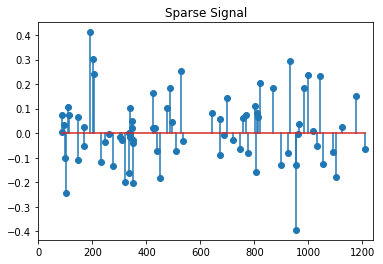

('class1', 0.96527777777777779)
('class2', 0.98611111111111116)
('class3', 0.96527777777777779)
('class4', 0.93055555555555558)


('class1', 0.96527777777777779)
('class2', 0.96527777777777779)
('class3', 0.96527777777777779)
('class4', 0.90277777777777779)




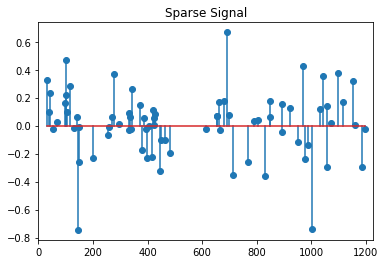

('class1', 0.94444444444444442)
('class2', 0.96527777777777779)
('class3', 0.94444444444444442)
('class4', 0.90277777777777779)




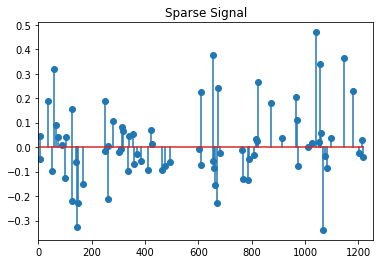

('class1', 0.93055555555555558)
('class2', 0.9375)
('class3', 0.93055555555555558)
('class4', 0.82638888888888884)




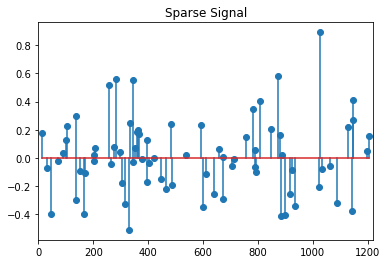

('class1', 0.94444444444444442)
('class2', 0.95833333333333337)
('class3', 0.94444444444444442)
('class4', 0.94444444444444442)


('class1', 0.96527777777777779)
('class2', 0.94444444444444442)
('class3', 0.96527777777777779)
('class4', 0.9375)


('class1', 0.92361111111111116)
('class2', 0.9375)
('class3', 0.92361111111111116)
('class4', 0.89583333333333337)




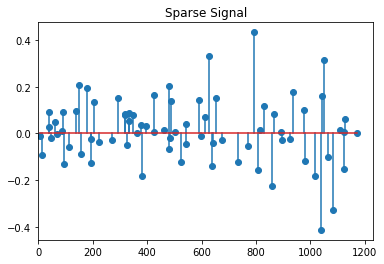

('class1', 0.96527777777777779)
('class2', 0.97222222222222221)
('class3', 0.96527777777777779)
('class4', 0.90277777777777779)




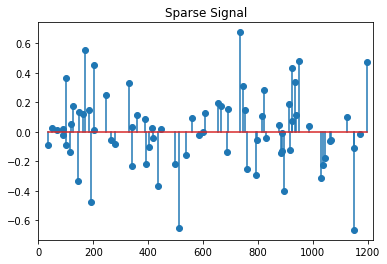

('class1', 0.97222222222222221)
('class2', 0.97222222222222221)
('class3', 0.97916666666666663)
('class4', 0.88888888888888884)


('class1_average:', 0.94791666666666663)
('class2_average:', 0.95694444444444426)
('class3_average:', 0.94861111111111107)
('class4_average:', 0.89722222222222237)
--- 13.460515976 seconds ---


In [13]:
## K fold cross validation on wavelet
import time

from sklearn.model_selection import KFold

#dictionary = dictionary_bandpower
dictionary = dictionary_wavelet
#dictionary = dictionary_dct

kf = KFold(n_splits=10, random_state=30, shuffle=True)
kf.get_n_splits(dictionary)

y = np.array(y_we)

y_classifier1 = []
y_classifier2 = []
y_classifier3 = []
y_classifier4 = []

avg1 = 0
avg2 = 0
avg3 = 0
avg4 = 0

a1 = 0
a2 = 0
a3 = 0
a4 = 0
minimum = 0

y_all1 = []
y_all2 = []
y_all3 = []
y_all4 = []
y_example_test = []

reb_dictionary = []

y_final_test = []

print(kf)

start_time = time.time()

for train_index, test_index in kf.split(dictionary):
    X_train, X_test = dictionary[train_index], dictionary[test_index]
    y_train, y_test = y[train_index], y[test_index]
    class1 = 0
    class2 = 0
    class3 = 0
    class4 = 0
    for i in range(len(y_train)):
        if (y_train[i] == 0):
            class1 += 1
        elif (y_train[i] == 1):
            class2 += 1
        elif (y_train[i] == 2):
            class3 += 1
        else:
            class4 += 1

    minimum = min(min(class1, class2), min(class3, class4))
    reb_y = []
    reb_dic = []
    count = 0
    iterator = 0
    while (count < minimum):
        if y_train[iterator] == 0:
            reb_dic.append(X_train[iterator])
            reb_y.append(0)
            count += 1
        iterator += 1

    count = 0
    iterator = 0
    while (count < minimum):
        if y_train[iterator] == 1:
            reb_dic.append(X_train[iterator])
            reb_y.append(1)
            count += 1
        iterator += 1

    count = 0
    iterator = 0
    while (count < minimum):
        if y_train[iterator] == 2:
            reb_dic.append(X_train[iterator])
            reb_y.append(2)
            count += 1
        iterator += 1

    count = 0
    iterator = 0
    while (count < minimum):
        if y_train[iterator] == 3:
            reb_dic.append(X_train[iterator])
            reb_y.append(3)
            count += 1
        iterator += 1

    reb_dictionary = np.array(reb_dic)
    reb_dictionary = reb_dictionary.transpose()

    y_classifier1, y_classifier2, y_classifier3, y_classifier4, a1, a2, a3, a4 = calculate_accuracy(
        X_test, y_test, reb_dictionary, minimum)

    y_all1.extend(y_classifier1)
    y_all2.extend(y_classifier2)
    y_all3.extend(y_classifier3)
    y_all4.extend(y_classifier4)

    y_final_test.extend(y_test)

    avg1 += a1
    avg2 += a2
    avg3 += a3
    avg4 += a4

print('class1_average:', avg1 / 10)
print('class2_average:', avg2 / 10)
print('class3_average:', avg3 / 10)
print('class4_average:', avg4 / 10)

print("--- %s seconds ---" % (time.time() - start_time))

In [14]:
# Test case running time for 1 test case
start_time = time.time()
y_classifier1, y_classifier2, y_classifier3, y_classifier4, a1, a2, a3, a4 = calculate_accuracy(
    np.reshape(X_test[0], (1, -1)), np.reshape(y_test[0], (1, -1)),
    reb_dictionary, minimum)
print("--- %s seconds ---" % (time.time() - start_time))

('class1', 1.0)
('class2', 1.0)
('class3', 1.0)
('class4', 1.0)


--- 0.0228259563446 seconds ---


KFold(n_splits=10, random_state=30, shuffle=True)


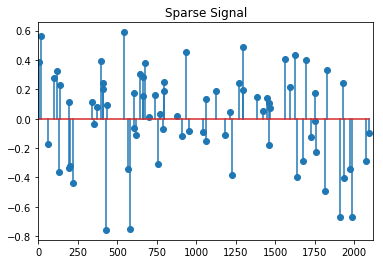

('class1', 0.98333333333333328)
('class2', 0.97916666666666663)
('class3', 0.98333333333333328)
('class4', 0.97499999999999998)


('class1', 0.9916666666666667)
('class2', 0.9916666666666667)
('class3', 0.9916666666666667)
('class4', 0.97916666666666663)


('class1', 0.98333333333333328)
('class2', 0.98333333333333328)
('class3', 0.98333333333333328)
('class4', 0.97499999999999998)




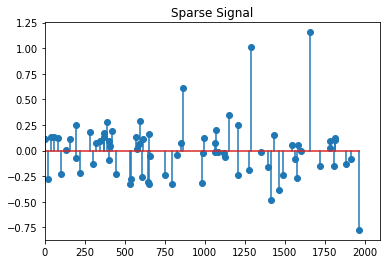

('class1', 0.97916666666666663)
('class2', 0.97916666666666663)
('class3', 0.97916666666666663)
('class4', 0.97916666666666663)


('class1', 0.99583333333333335)
('class2', 0.99583333333333335)
('class3', 0.99583333333333335)
('class4', 0.98333333333333328)




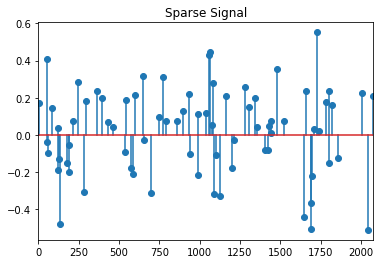

('class1', 0.9916666666666667)
('class2', 0.9916666666666667)
('class3', 0.9916666666666667)
('class4', 0.98750000000000004)


('class1', 0.98750000000000004)
('class2', 0.98750000000000004)
('class3', 0.98750000000000004)
('class4', 0.9916666666666667)


('class1', 0.9916666666666667)
('class2', 0.98750000000000004)
('class3', 0.9916666666666667)
('class4', 0.97083333333333333)


('class1', 0.9916666666666667)
('class2', 0.9916666666666667)
('class3', 0.9916666666666667)
('class4', 0.95833333333333337)


('class1', 0.9916666666666667)
('class2', 0.98750000000000004)
('class3', 0.9916666666666667)
('class4', 0.97083333333333333)


('class1_average:', 0.98875000000000013)
('class2_average:', 0.98750000000000004)
('class3_average:', 0.98875000000000013)
('class4_average:', 0.97708333333333341)
--- 25.1946210861 seconds ---


In [23]:
## K fold cross validation on bandpower
import time

from sklearn.model_selection import KFold

dictionary = dictionary_bandpower
#dictionary = dictionary_wavelet
#dictionary = dictionary_dct

kf = KFold(n_splits=10, random_state=30, shuffle=True)
kf.get_n_splits(dictionary)

y = np.array(y_we)

y_classifier1 = []
y_classifier2 = []
y_classifier3 = []
y_classifier4 = []

avg1 = 0
avg2 = 0
avg3 = 0
avg4 = 0

a1 = 0
a2 = 0
a3 = 0
a4 = 0
minimum = 0

y_all1 = []
y_all2 = []
y_all3 = []
y_all4 = []
y_example_test = []

reb_dictionary = []

y_final_test = []

print(kf)

start_time = time.time()

for train_index, test_index in kf.split(dictionary):
    X_train, X_test = dictionary[train_index], dictionary[test_index]
    y_train, y_test = y[train_index], y[test_index]
    class1 = 0
    class2 = 0
    class3 = 0
    class4 = 0
    for i in range(len(y_train)):
        if (y_train[i] == 0):
            class1 += 1
        elif (y_train[i] == 1):
            class2 += 1
        elif (y_train[i] == 2):
            class3 += 1
        else:
            class4 += 1

    minimum = min(min(class1, class2), min(class3, class4))
    reb_y = []
    reb_dic = []
    count = 0
    iterator = 0
    while (count < minimum):
        if y_train[iterator] == 0:
            reb_dic.append(X_train[iterator])
            reb_y.append(0)
            count += 1
        iterator += 1

    count = 0
    iterator = 0
    while (count < minimum):
        if y_train[iterator] == 1:
            reb_dic.append(X_train[iterator])
            reb_y.append(1)
            count += 1
        iterator += 1

    count = 0
    iterator = 0
    while (count < minimum):
        if y_train[iterator] == 2:
            reb_dic.append(X_train[iterator])
            reb_y.append(2)
            count += 1
        iterator += 1

    count = 0
    iterator = 0
    while (count < minimum):
        if y_train[iterator] == 3:
            reb_dic.append(X_train[iterator])
            reb_y.append(3)
            count += 1
        iterator += 1

    reb_dictionary = np.array(reb_dic)
    reb_dictionary = reb_dictionary.transpose()

    y_classifier1, y_classifier2, y_classifier3, y_classifier4, a1, a2, a3, a4 = calculate_accuracy(
        X_test, y_test, reb_dictionary, minimum)

    y_all1.extend(y_classifier1)
    y_all2.extend(y_classifier2)
    y_all3.extend(y_classifier3)
    y_all4.extend(y_classifier4)

    y_final_test.extend(y_test)

    avg1 += a1
    avg2 += a2
    avg3 += a3
    avg4 += a4

print('class1_average:', avg1 / 10)
print('class2_average:', avg2 / 10)
print('class3_average:', avg3 / 10)
print('class4_average:', avg4 / 10)

print("--- %s seconds ---" % (time.time() - start_time))

In [24]:
dictionary.shape

(2400, 120)

In [15]:
#plot confusion matrix

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[558   5   4   9]
 [ 11 568  16   7]
 [  8  11 562   8]
 [ 13  17  19 584]]
Normalized confusion matrix
[[ 0.97  0.01  0.01  0.02]
 [ 0.02  0.94  0.03  0.01]
 [ 0.01  0.02  0.95  0.01]
 [ 0.02  0.03  0.03  0.92]]


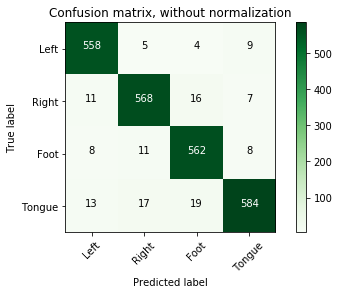

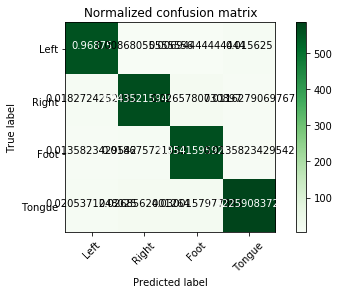

In [16]:
cnf_matrix = confusion_matrix(y_final_test, y_all4)
np.set_printoptions(precision=2)
class_names = ["Left", "Right", "Foot", "Tongue"]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix,
    classes=class_names,
    title='Confusion matrix, without normalization')
#plt.savefig('Results/With 0.2s /CM_WN_S3.eps', format='eps', dpi=1000)
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix,
    classes=class_names,
    normalize=True,
    title='Normalized confusion matrix')
#plt.savefig('Results/With 0.2s /CM_N_S3.eps', format='eps', dpi=1000)
plt.show()

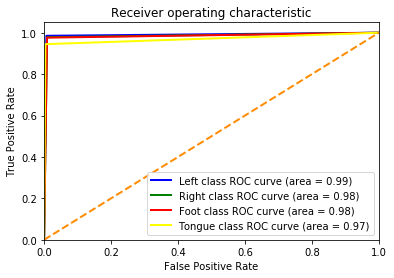

In [17]:
## Plot ROC curve

count = 0
iterator = 0
real0 = []
pred0 = []

real1 = []
pred1 = []

real2 = []
pred2 = []

real3 = []
pred3 = []

while (iterator < len(y_final_test)):
    if (y_final_test[iterator] == 0):
        real0.append(0)
        if (y_all1[iterator] == 0):
            pred0.append(0)
        else:
            pred0.append(1)
    else:
        real0.append(1)
        if (y_all1[iterator] == 0):
            pred0.append(0)
        else:
            pred0.append(1)
    iterator += 1

iterator = 0
while (iterator < len(y_final_test)):
    if (y_final_test[iterator] == 1):
        real1.append(1)
        if (y_all1[iterator] == 1):
            pred1.append(1)
        else:
            pred1.append(0)
    else:
        real1.append(0)
        if (y_all1[iterator] == 1):
            pred1.append(1)
        else:
            pred1.append(0)
    iterator += 1

iterator = 0
while (iterator < len(y_final_test)):
    if (y_final_test[iterator] == 2):
        real2.append(1)
        if (y_all1[iterator] == 2):
            pred2.append(1)
        else:
            pred2.append(0)
    else:
        real2.append(0)
        if (y_all1[iterator] == 2):
            pred2.append(1)
        else:
            pred2.append(0)
    iterator += 1

iterator = 0
while (iterator < len(y_final_test)):
    if (y_final_test[iterator] == 3):
        real3.append(1)
        if (y_all1[iterator] == 3):
            pred3.append(1)
        else:
            pred3.append(0)
    else:
        real3.append(0)
        if (y_all1[iterator] == 3):
            pred3.append(1)
        else:
            pred3.append(0)
    iterator += 1

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

fpr, tpr, _ = roc_curve(real0, pred0)
roc_auc = auc(fpr, tpr)

fpr1, tpr1, _ = roc_curve(real1, pred1)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(real2, pred2)
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, _ = roc_curve(real3, pred3)
roc_auc3 = auc(fpr3, tpr3)

plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color='blue',
    lw=lw,
    label='Left class ROC curve (area = %0.2f)' % roc_auc)

plt.plot(
    fpr1,
    tpr1,
    color='green',
    lw=lw,
    label='Right class ROC curve (area = %0.2f)' % roc_auc1)

plt.plot(
    fpr2,
    tpr2,
    color='red',
    lw=lw,
    label='Foot class ROC curve (area = %0.2f)' % roc_auc2)

plt.plot(
    fpr3,
    tpr3,
    color='yellow',
    lw=lw,
    label='Tongue class ROC curve (area = %0.2f)' % roc_auc3)
plt.plot([0, 1], [0, 1], color='darkorange', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Results/With 0.2s /ROC_S3.eps', format='eps', dpi=1000)
plt.show()

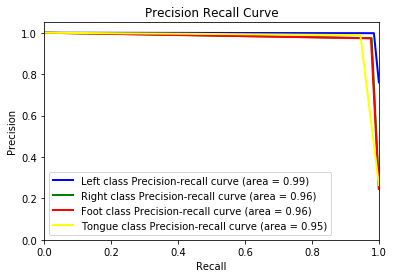

In [18]:
## Plot precision recall curve

import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Compute Precision-Recall and plot curve
precision = []
recall = []
average_precision = []

precision, recall, thresholds = precision_recall_curve(real0, pred0)

average_precision = average_precision_score(real0, pred0)

precision1, recall1, thresholds1 = precision_recall_curve(real1, pred1)

average_precision1 = average_precision_score(real1, pred1)

precision2, recall2, thresholds2 = precision_recall_curve(real2, pred2)

average_precision2 = average_precision_score(real2, pred2)

precision3, recall3, thresholds3 = precision_recall_curve(real3, pred3)

average_precision3 = average_precision_score(real3, pred3)

# Plot Precision-Recall curve
plt.clf()
plt.plot(
    recall,
    precision,
    lw=lw,
    color='blue',
    label='Left class Precision-recall curve (area = {0:0.2f})'
    ''.format(average_precision))

plt.plot(
    recall1,
    precision1,
    lw=lw,
    color='green',
    label='Right class Precision-recall curve (area = {0:0.2f})'
    ''.format(average_precision1))

plt.plot(
    recall2,
    precision2,
    lw=lw,
    color='red',
    label='Foot class Precision-recall curve (area = {0:0.2f})'
    ''.format(average_precision2))

plt.plot(
    recall3,
    precision3,
    lw=lw,
    color='yellow',
    label='Tongue class Precision-recall curve (area = {0:0.2f})'
    ''.format(average_precision3))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision Recall Curve")

plt.legend(loc="lower left")
#plt.savefig('Results/With 0.2s /PR_S3.eps', format='eps', dpi=1000)
plt.show()
#plt.savefig('precision_S3.eps', format='eps', dpi=1000)